In [1]:
##### diagnostic
from Diagnostic_functions import *
import argparse

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--var_t', type=float, required=False,
    help='variable: pulse_duration [fs]')
parser.add_argument('--err_E', type=float, required=False,
    help='error: photon energy [meV]')
parser.add_argument('--err_f0', type=float, required=False,
    help='error: collimation lens focal distance [m]')
parser.add_argument('--err_f1', type=float, required=False,
    help='error: crystal-lens distance [m]')
parser.add_argument('--C', type=str, required=False,
    help='crystal name [string]')
parser.add_argument('--err_delta', type=float, required=False,
    help='error: crystal alignment [urad]')
parser.add_argument('--err_miscut', type=float, required=False,
    help='error: crystal miscut [urad]')
parser.add_argument('--if_log', type=int, required=False,
    help='condition: log scale plots')
parser.add_argument('--if_slice', type=int, required=False,
    help='condition: y=0 slice plots')
parser.add_argument('--if_close', type=int, required=False,
    help='condition: closed slit')


args = parser.parse_args()

var_t = args.var_t
err_E = args.err_E
err_f0 = args.err_f0
err_f1 = args.err_f1

cname = args.C
err_delta = args.err_delta
err_miscut = args.err_miscut

if_log = args.if_log
if_slice = args.if_slice
if_close = args.if_close

err_name = ''
err_val_name = ''

if var_t is None: var_t = 400

if err_E is None: err_E = 0.
else: err_name += '_E'; err_val_name += '_{}meV'.format(round(err_E,3))

if err_f0 is None: err_f0 = 0.
else: err_name += '_f0'; err_val_name += '_{}m'.format(round(err_f0,3))

if err_f1 is None: err_f1 = 0.
else: err_name += '_f1'; err_val_name += '_{}m'.format(round(err_f1,3))

if cname is None: cname = 'HHLM1'

if err_delta is None: err_delta = 0.
else: err_name += '_delta_{}'.format(cname); err_val_name += '_{}urad'.format(round(err_delta,3))

if err_miscut is None: err_miscut = 0.
else: err_name += '_miscut_{}'.format(cname); err_val_name += '_{}urad'.format(round(err_miscut,3))

if if_log is None: if_log = 1
if if_slice is None: if_slice = 1
if if_close is None: if_close = 0

print('arguments: {}'.format([var_t, err_E, err_f0, err_f1, err_delta, err_miscut]))
print('error type: {}, error value: {}'.format(err_name, err_val_name))
print('if_log {}, if_close {}, if_slice {}'.format(if_log, if_close, if_slice))

arguments: [400, 0.0, 0.0, 0.0, 0.0, 0.0]
error type: , error value: 
if_log 1, if_close 0, if_slice 1


In [3]:
##### sampling parameters
sigT = var_t * 1e-15/2.355
E = 9481.
d_slit = 7e-6

t_res =sigT*2.355/10              # time sampling resolution [s]
ev_window = 4/t_res *1e-15        # total energy window [eV]
ev_res = min(ev_window/400, 1e-3) # energy sampling resolution [eV]


range_x = 4e-3; range_y = 4e-3
nx = 2048; ny = 8; nz = 2*round(ev_window/ev_res/2)
ny_reduced = 8

x_res = range_x/nx
y_res = range_y/ny
t_window = t_res*nz          # total time window [s]

pulseRange = int(t_window/sigT)
factor = -1 # factor = 0.5

print('nx, ny, nz: {}'.format([nx, ny, nz]))
print('x resolution/range: {}/ {}um'.format(round(x_res*1e6,2), round(range_x*1e6,2)))
print('y resolution/range: {}/ {}um'.format(round(y_res*1e6,2), round(range_y*1e6,2)))
print('time resolution/range: {}/ {}fs'.format(round(t_res*1e15,2), round(t_window*1e15,2)))
print('energy resolution/range: {}/ {}meV'.format(round(ev_res*1e3,2), round(ev_window*1e3,2)))

# I/O directories
dir_output = 'output/'
# dir_case = dir_output+'Loop/'
dir_case = dir_output+'Single_mir/'
dir_param = dir_case+'{}fs{}/'.format(round(sigT*2.355*1e15,2), err_name)
dir_plot = dir_param+'{}fs_{}meV{}/'.format(round(t_window*1e15,1),round(ev_window*1e3,1), err_val_name)


nx, ny, nz: [2048, 8, 400]
x resolution/range: 1.95/ 4000.0um
y resolution/range: 500.0/ 4000.0um
time resolution/range: 40.0/ 16000.0fs
energy resolution/range: 0.25/ 100.0meV


In [4]:
##### general lens calculations
def rCRL(fCRL, nCRL):
    # calculates the min radius of curvature of each lens
    if E == 9481.: return 7.58227e-06*fCRL/nCRL
    if E == 17795.: return 2.151005735797996e-06*fCRL/nCRL

name_CRL = ['CRL0', 'MIR1', 'MIR2']
fCRL_list = [290, 10, 10]
nCRL_list = [1, 1, 1]


In [5]:
# I/O
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

for dir_name in [dir_output, dir_case, dir_param, dir_plot]:
    mkdir(dir_name); print('directory created: {}\n'.format(dir_name))


directory created: output/

directory created: output/Single_mir/

directory created: output/Single_mir/400.0fs/

directory created: output/Single_mir/400.0fs/16000.0fs_100.0meV/



In [6]:
## define bl CC1
def set_optics_CRL0_before_MIR1(v=None):
    el = []
    pp = []
    names = ['CRL','CRL_MIR1']
    for el_name in names:
        if el_name == 'CRL':
            # CRL: crl 290.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL_foc_plane,
                _delta=v.op_CRL_delta,
                _atten_len=v.op_CRL_atten_len,
                _shape=v.op_CRL_shape,
                _apert_h=v.op_CRL_apert_h,
                _apert_v=v.op_CRL_apert_v,
                _r_min=v.op_CRL_r_min,
                _n=v.op_CRL_n,
                _wall_thick=v.op_CRL_wall_thick,
                _xc=v.op_CRL_x,
                _yc=v.op_CRL_y,
            ))
            pp.append(v.op_CRL_pp)
        elif el_name == 'CRL_MIR1':
            # CRL_C1: drift 290.0m
            el.append(srwlib.SRWLOptD(
                _L=10.,
            ))
            pp.append(v.op_CRL_MIR1_pp)
    return srwlib.SRWLOptC(el, pp)


## define bl telescope
def set_optics_MIR1_focus(v=None):
    el = []
    pp = []
    names = ['MIR1','MIR1_Slit']
    for el_name in names:
        if el_name == 'MIR1':
            # MIR1: ellipsoidMirror 300.0m
            el.append(srwlib.SRWLOptMirEl(
                _p=v.op_MIR1_p,
                _q=v.op_MIR1_q,
                _ang_graz=v.op_MIR1_ang,
                _size_tang=v.op_MIR1_size_tang,
                _size_sag=v.op_MIR1_size_sag,
                _nvx=v.op_MIR1_nvx,
                _nvy=v.op_MIR1_nvy,
                _nvz=v.op_MIR1_nvz,
                _tvx=v.op_MIR1_tvx,
                _tvy=v.op_MIR1_tvy,
                _x=v.op_MIR1_x,
                _y=v.op_MIR1_y,
            ))
            pp.append(v.op_MIR1_pp)
        elif el_name == 'MIR1_Slit':
            # MIR1_Slit: drift 300.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_MIR1_Slit_L,
            ))
            pp.append(v.op_MIR1_Slit_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_focus_MIR2(v=None):
    el = []
    pp = []
    names = ['Slit_MIR2','MIR2']
    for el_name in names:
        if el_name == 'Slit_MIR2':
            # Slit_MIR2: drift 310.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_Slit_MIR2_L,
            ))
            pp.append(v.op_Slit_MIR2_pp)
        elif el_name == 'MIR2':
            # MIR2: ellipsoidMirror 320.0m
            el.append(srwlib.SRWLOptMirEl(
                _p=v.op_MIR2_p,
                _q=v.op_MIR2_q,
                _ang_graz=v.op_MIR2_ang,
                _size_tang=v.op_MIR2_size_tang,
                _size_sag=v.op_MIR2_size_sag,
                _nvx=v.op_MIR2_nvx,
                _nvy=v.op_MIR2_nvy,
                _nvz=v.op_MIR2_nvz,
                _tvx=v.op_MIR2_tvx,
                _tvy=v.op_MIR2_tvy,
                _x=v.op_MIR2_x,
                _y=v.op_MIR2_y,
            ))
            pp.append(v.op_MIR2_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_drift(v=None, d=10.0):
    el = []
    pp = []
    names = ['drift']
    for el_name in names:
        if el_name == 'drift':
            # MIR2_output: drift 320.0m
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_MIR2_output_L,
                _L=d,
            ))
            pp.append(v.op_MIR2_output_pp)
    return srwlib.SRWLOptC(el, pp)



In [7]:
varParam = srwl_bl.srwl_uti_ext_options([
    ['name', 's', 'full_beamline', 'simulation name'],

#---Data Folder
    ['fdir', 's', '', 'folder (directory) name for reading-in input and saving output data files'],


    ['gbm_x', 'f', 0.0, 'average horizontal coordinates of waist [m]'],
    ['gbm_y', 'f', 0.0, 'average vertical coordinates of waist [m]'],
    ['gbm_z', 'f', 0.0, 'average longitudinal coordinate of waist [m]'],
    ['gbm_xp', 'f', 0.0, 'average horizontal angle at waist [rad]'],
    ['gbm_yp', 'f', 0.0, 'average verical angle at waist [rad]'],
    ['gbm_ave', 'f', E+err_E, 'average photon energy [eV]'],
    ['gbm_pen', 'f', 0.001, 'energy per pulse [J]'],
    ['gbm_rep', 'f', 1, 'rep. rate [Hz]'],
    ['gbm_pol', 'f', 2, 'polarization 1- lin. hor., 2- lin. vert., 3- lin. 45 deg., 4- lin.135 deg., 5- circ. right, 6- circ. left'],
    ['gbm_sx', 'f', 9.787229999999999e-06, 'rms beam size vs horizontal position [m] at waist (for intensity)'],
    ['gbm_sy', 'f', 9.787229999999999e-06, 'rms beam size vs vertical position [m] at waist (for intensity)'],
    ['gbm_st', 'f', sigT, 'rms pulse duration [s] (for intensity)'],
    ['gbm_mx', 'f', 0, 'transverse Gauss-Hermite mode order in horizontal direction'],
    ['gbm_my', 'f', 0, 'transverse Gauss-Hermite mode order in vertical direction'],
    ['gbm_ca', 's', 'c', 'treat _sigX, _sigY as sizes in [m] in coordinate representation (_presCA="c") or as angular divergences in [rad] in angular representation (_presCA="a")'],
    ['gbm_ft', 's', 't', 'treat _sigT as pulse duration in [s] in time domain/representation (_presFT="t") or as bandwidth in [eV] in frequency domain/representation (_presFT="f")'],

#---Calculation Types
    #Single-Electron Intensity distribution vs horizontal and vertical position
    ['si', '', '', 'calculate single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position', 'store_true'],
    #Single-Electron Wavefront Propagation
    ['ws', '', '', 'calculate single-electron (/ fully coherent) wavefront propagation', 'store_true'],
    #Multi-Electron (partially-coherent) Wavefront Propagation
    ['wm', '', '', 'calculate multi-electron (/ partially coherent) wavefront propagation', 'store_true'],

    ['w_e', 'f', -pulseRange*sigT/2, 'photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ef', 'f', pulseRange*sigT/2, 'final photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ne', 'i', nz, 'number of points vs photon energy for calculation of intensity distribution'],
    ['w_x', 'f', 0.0, 'central horizontal position [m] for calculation of intensity distribution'],
    ['w_rx', 'f', range_x, 'range of horizontal position [m] for calculation of intensity distribution'],
    ['w_nx', 'i', nx, 'number of points vs horizontal position for calculation of intensity distribution'],
    ['w_y', 'f', 0.0, 'central vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ry', 'f', range_y, 'range of vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ny', 'i', ny, 'number of points vs vertical position for calculation of intensity distribution'],
    ['w_smpf', 'f', factor, 'sampling factor for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_meth', 'i', 2, 'method to use for calculation of intensity distribution vs horizontal and vertical position: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"'],
    ['w_prec', 'f', 0.01, 'relative precision for calculation of intensity distribution vs horizontal and vertical position'],

    ['w_ft', 's', 't', 'presentation/domain: "f"- frequency (photon energy), "t"- time'],

    ['w_u', 'i', 2, 'electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)'],
    ['si_pol', 'i', 6, 'polarization component to extract after calculation of intensity distribution: 0- Linear Horizontal, 1- Linear Vertical, 2- Linear 45 degrees, 3- Linear 135 degrees, 4- Circular Right, 5- Circular Left, 6- Total'],
    ['si_type', 'i', 0, 'type of a characteristic to be extracted after calculation of intensity distribution: 0- Single-Electron Intensity, 1- Multi-Electron Intensity, 2- Single-Electron Flux, 3- Multi-Electron Flux, 4- Single-Electron Radiation Phase, 5- Re(E): Real part of Single-Electron Electric Field, 6- Im(E): Imaginary part of Single-Electron Electric Field, 7- Single-Electron Intensity, integrated over Time or Photon Energy'],
    
    ['si_fn', 's', 'res_int_se.dat', 'file name for saving calculated single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position'],
    ['si_pl', 's', '', 'plot the input intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],
    ['ws_fni', 's', 'res_int_pr_se.dat', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'],
    ['ws_pl', 's', '', 'plot the resulting intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],

    #to add options
    ['op_r', 'f', fCRL_list[0], 'longitudinal position of the first optical element [m]'],
    # Former appParam:
    ['rs_type', 's', 'g', 'source type, (u) idealized undulator, (t), tabulated undulator, (m) multipole, (g) gaussian beam'],

#---Beamline optics:
    # CRL: crl
    ['op_CRL_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL_shape', 'f', 1, 'shape'],
    ['op_CRL_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL_r_min', 'f', rCRL(fCRL_list[0], nCRL_list[0]), 'tipRadius'],
    ['op_CRL_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL_n', 'i', nCRL_list[0], 'numberOfLenses'],

    # CRL_HHLM1: drift
    ['op_CRL_C1_L', 'f', 5.0, 'length'],
    
    # MIR1: ellipsoidMirror
    ['op_MIR1_hfn', 's', 'None', 'heightProfileFile'],
    ['op_MIR1_dim', 's', 'x', 'orientation'],
    ['op_MIR1_p', 'f', 1e5, 'firstFocusLength'],
    ['op_MIR1_q', 'f', fCRL_list[1], 'focalLength'],
    ['op_MIR1_ang', 'f', 0.0036, 'grazingAngle'],
    ['op_MIR1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_MIR1_size_tang', 'f', 5e-3/np.sin(0.0036), 'tangentialSize'],
    ['op_MIR1_size_sag', 'f', 5e-3, 'sagittalSize'],
    ['op_MIR1_nvx', 'f', 0.9999935200069984, 'normalVectorX'],
    ['op_MIR1_nvy', 'f', 0.0, 'normalVectorY'],
    ['op_MIR1_nvz', 'f', -0.0035999922240050387, 'normalVectorZ'],
    ['op_MIR1_tvx', 'f', 0.0035999922240050387, 'tangentialVectorX'],
    ['op_MIR1_tvy', 'f', 0.0, 'tangentialVectorY'],
    ['op_MIR1_x', 'f', 0.0, 'horizontalOffset'],
    ['op_MIR1_y', 'f', 0.0, 'verticalOffset'],

    # MIR1_Slit: drift
    ['op_MIR1_Slit_L', 'f', fCRL_list[1], 'length'],
    
    # Slit_MIR2: drift
    ['op_Slit_MIR2_L', 'f', fCRL_list[2], 'length'],
    
    # MIR2: ellipsoidMirror
    ['op_MIR2_hfn', 's', 'None', 'heightProfileFile'],
    ['op_MIR2_dim', 's', 'x', 'orientation'],
    ['op_MIR2_p', 'f', fCRL_list[2], 'firstFocusLength'],
    ['op_MIR2_q', 'f', 1e5, 'focalLength'],
    ['op_MIR2_ang', 'f', 0.0036, 'grazingAngle'],
    ['op_MIR2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_MIR2_size_tang', 'f', 5e-3/np.sin(0.0036), 'tangentialSize'],
    ['op_MIR2_size_sag', 'f', 5e-3, 'sagittalSize'],
    ['op_MIR2_nvx', 'f', 0.9999935200069984, 'normalVectorX'],
    ['op_MIR2_nvy', 'f', 0.0, 'normalVectorY'],
    ['op_MIR2_nvz', 'f', -0.0035999922240050387, 'normalVectorZ'],
    ['op_MIR2_tvx', 'f', 0.0035999922240050387, 'tangentialVectorX'],
    ['op_MIR2_tvy', 'f', 0.0, 'tangentialVectorY'],
    ['op_MIR2_x', 'f', 0.0, 'horizontalOffset'],
    ['op_MIR2_y', 'f', 0.0, 'verticalOffset'],
    
    # MIR2_output: drift
    ['op_MIR2_output_L', 'f', 10.0, 'length'],


#---Propagation parameters
#                                   [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
    ['op_CRL_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL'],
    ['op_CRL_MIR1_pp', 'f',         [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL_HHLM1'],
    ['op_MIR1_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR1'],
    ['op_MIR1_Slit_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR1_Slit'],
    ['op_Slit_MIR2_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Slit_MIR2'],
    ['op_MIR2_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR2'],
    ['op_MIR2_output_pp', 'f',      [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'MIR2_output'],
    ['op_fin_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'final post-propagation (resize) parameters'],

    #[ 0]: Auto-Resize (1) or not (0) Before propagation
    #[ 1]: Auto-Resize (1) or not (0) After propagation
    #[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
    #[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
    #[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
    #[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
    #[ 6]: Horizontal Resolution modification factor at Resizing
    #[ 7]: Vertical Range modification factor at Resizing
    #[ 8]: Vertical Resolution modification factor at Resizing
    #[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
    #[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
    #[11]: New Vertical wavefront Center position after Shift (not yet implemented)
    #[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
    #[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
    #[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
    #[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
    #[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
])


In [8]:
def plot_wfr_diagnostic(_wfr, label=None, dir_plot=None, if_slice=1, if_log=0, i=0, i_start=0):
    '''
    if_slice: y = 0 slice only or full projection
    if_log: log scale in imshow plots
    i: plot index, make I/O easier
    i_start: minimum plot index, only indices >= i_start will be plotted
    '''
    if i < i_start: print('plot skipped')
    else:
        np.seterr(divide = 'ignore')
        nx, ny, nz = get_dimension(_wfr)
        # I/O plot name
        nx, ny, nz = get_dimension(_wfr)    # get dimension
        if if_log == 1:
            pltname = '{}_{}_nx{}_ny{}_nz{}_log.png'.format(i,label,nx,ny,nz)
        else:
            pltname = '{}_{}_nx{}_ny{}_nz{}.png'.format(i,label,nx,ny,nz)

        ''' some calculations '''
        # space
        title_space = label + ', '
        axis_x, axis_y = get_axis_sp(_wfr)      # spatial axis [m]
        res_x = round(np.abs(axis_x[1] - axis_x[0])*1e6,2)  # spatial resolution
        try:
            cent_x, cent_y, fwhm_x, fwhm_y = fit_pulse_position(_wfr)   # fit for pulse position and width
            xstart = cent_x - fwhm_x*10; xfin = cent_x + fwhm_x*10
            ystart = cent_y - fwhm_y*10; yfin = cent_y + fwhm_y*10
            title_space+= 'x size: {}um, '.format(round(fwhm_x*1e6,2))
        except:
            xstart = axis_x.min(); xfin = axis_x.max()
            ystart = axis_y.min(); yfin = axis_y.max()
        xstart = max(axis_x.min()*1e6, xstart*1e6); xfin = min(axis_x.max()*1e6, xfin*1e6)
        ystart = max(axis_y.min()*1e6, ystart*1e6); yfin = min(axis_y.max()*1e6, yfin*1e6)
        title_space += 'resolution: {}um'.format(res_x)

        # energy
        title_energy = ''
        axis_ev = get_axis_ev(_wfr)     # energy axis [eV]
        axis_ev = axis_ev - axis_ev[int(axis_ev.size/2)]        # shifted energy axis
        res_ev = round(np.abs(axis_ev[1] - axis_ev[0])*1e3,2)   # energy resolution
        try:
            cent_E, fwhm_E = fit_pulse_bandwidth(_wfr)      # fit for pulse central energy and bandwidth
            Estart = -fwhm_E*10*1e3; Efin = fwhm_E*10*1e3
            title_energy += 'bandwidth: {}meV, '.format(round(fwhm_E*1e3,2))
        except:
            Estart = axis_ev.min()*1e3; Efin = axis_ev.max()*1e3
        Estart = max(axis_ev.min()*1e3, Estart); Efin = min(axis_ev.max()*1e3, Efin)
        title_energy += 'resolution: {}meV'.format(res_ev)

        # time
        title_time = ''
        axis_t = get_axis_t(_wfr)       # time axis [s]
        res_t = round(np.abs(axis_t[1] - axis_t[0])*1e15,2)     # time resolution
        try:
            cent_t, fwhm_t = fit_pulse_duration(_wfr)       # fit for pulse duration
            tstart = cent_t - fwhm_t*10; tfin = cent_t + fwhm_t*10
            title_time += 'duration: {}fs, '.format(round(fwhm_t,2))
        except:
            tstart = axis_t.min()*1e15; tfin = axis_t.max()*1e15; fwhm_t = None
        tstart = max(axis_t.min()*1e15, tstart); tfin = min(axis_t.max()*1e15, tfin)
        try:
            tilt = round(fit_pulsefront_tilt(_wfr, dim='x'),2)     # [fs/um]
            title_time += 'tilt: {}fs/um, '.format(tilt)
        except:
            tilt = None
        title_time += 'resolution: {}fs'.format(res_t)

        # divergence
        try:
            h = 4.135667696e-15
            dif_lim = fwhm_t*1e-15 * fwhm_E/h*2
            print('del_t*del_E/h: {}'.format(round(dif_lim,5)))
        except:
            print('del_t*del_E/h cannot be calculated')
        
        t0 = time(); print('plotting {},\n'.format(label),
                           '[nx, ny, nz]: {}\n'.format([nx, ny, nz]),
                           'x range: {}um\n'.format(round((axis_x.max()-axis_x.min())*1e6,2)),
                           't range: {}fs\n'.format(round((axis_t.max()-axis_t.min())*1e15,2)),
                           'E range: {}meV\n'.format(round((axis_ev.max()-axis_ev.min())*1e3,2)))
        
        ''' plots '''
        plt.figure(figsize=(24,6))
        # space
        plt.subplot(1,3,1); plot_spatial_from_wf(_wfr, if_slice=if_slice, if_log=if_log)
#         plt.title(title_space); plt.axis('tight'); plt.xlim([-(range_x * x_scaling_HHLM/2)*1e6, (range_x * x_scaling_HHLM/2)*1e6])
#         plt.title(title_space); plt.axis('tight'); plt.xlim([-range_x/2*1e6, range_x/2*1e6])
        plt.title(title_space); plt.axis('tight'); plt.xlim([xstart, xfin])
        if if_slice != 1: plt.ylim([-range_y/2*1e6, range_y/2*1e6])

        # time
        plt.subplot(1,3,2); plot_tilt_from_wf(_wfr, ori='Horizontal', type='slice', if_log=if_log)
        plt.title(title_time); plt.xlim([tstart, tfin]); plt.ylim([xstart, xfin])

        # energy
        plt.subplot(1,3,3); plot_spatial_spectrum_from_wf(_wfr, ori='Horizontal', if_slice=0, if_log=if_log)
        plt.title(title_energy); plt.xlim([xstart, xfin]); plt.ylim([Estart, Efin])

        plt.savefig(dir_plot+pltname)
#         plt.close('all')
        np.seterr(divide = 'warn')
        print('plot lasted {}s\n'.format(round(time()-t0,2)))



In [9]:
def main(if_log=1, if_slice=1, d_slit=7e-6, i_start=0, if_close=0):
    # initialization
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    v.si = True
    srwl_bl.SRWLBeamline(_name=v.name).calc_all(v)
    
    # incident beam
    wfr = v.w_res; i_plot = 1
    plot_wfr_diagnostic(wfr, label='input', dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    srwlpy.SetRepresElecField(wfr, 'f')

    # before mirror 1
    label = 'before MIR1'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_CRL0_before_MIR1(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    # Telescope
    label = 'focus'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_MIR1_focus(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    label = 'after MIR2'; print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_focus_MIR2(v); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    
    d = 10.0
    label = '{}m after MIR2'.format(d); print('Propagating through {}: '.format(label), end=''); i_plot+=1; t0 = time()
    bl = set_optics_drift(v, d=d); srwlpy.PropagElecField(wfr, bl); print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label=label, dir_plot=dir_plot, i=i_plot, if_log=if_log, if_slice=if_slice, i_start=i_start)
    


Gaussian beam electric field calculation ... completed (lasted 2.638 s)
Extracting intensity and saving it to a file ... completed (lasted 12.957 s)


C:\Users\nanw0\anaconda3\envs\SRW\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


del_t*del_E/h: 0.86524
plotting input,
 [nx, ny, nz]: [2048, 8, 400]
 x range: 4000.0um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 8.22s

Propagating through before MIR1: Optical Element Setup: CRL Focal Length: 290.0 m
done in 4.789 s

del_t*del_E/h: 0.86512
plotting before MIR1,
 [nx, ny, nz]: [2048, 8, 400]
 x range: 4000.0um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 6.18s

Propagating through focus: done in 5.252 s

del_t*del_E/h: 0.86498
plotting focus,
 [nx, ny, nz]: [2048, 8, 400]
 x range: 291.91um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 8.5s

Propagating through after MIR2: done in 7.612 s

del_t*del_E/h: 0.865
plotting after MIR2,
 [nx, ny, nz]: [2048, 8, 400]
 x range: 4000.0um
 t range: 15966.03fs
 E range: 103.09meV

plot lasted 8.08s

Propagating through 10.0m after MIR2: done in 4.57 s

del_t*del_E/h: 0.86518
plotting 10.0m after MIR2,
 [nx, ny, nz]: [2048, 8, 400]
 x range: 3999.93um
 t range: 15966.03fs
 E range: 103.09meV

plot las

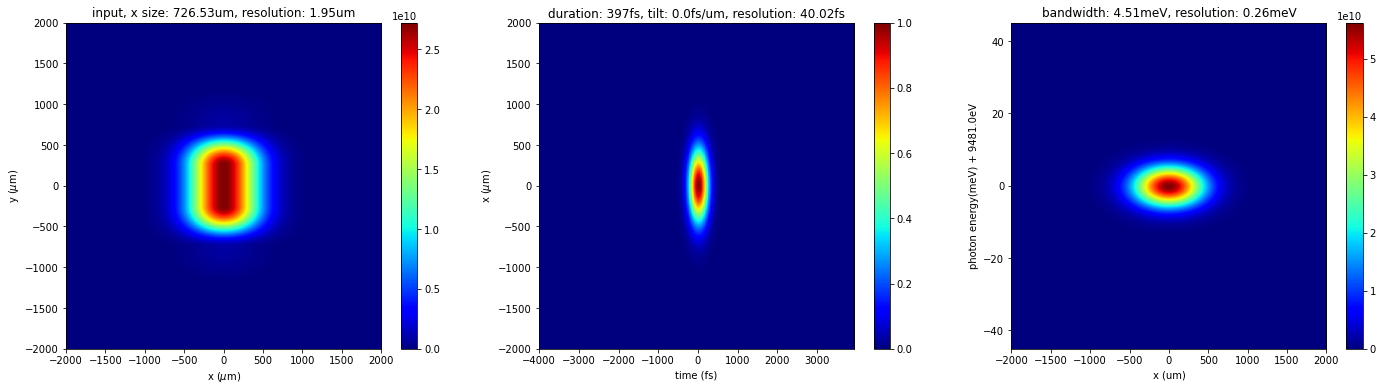

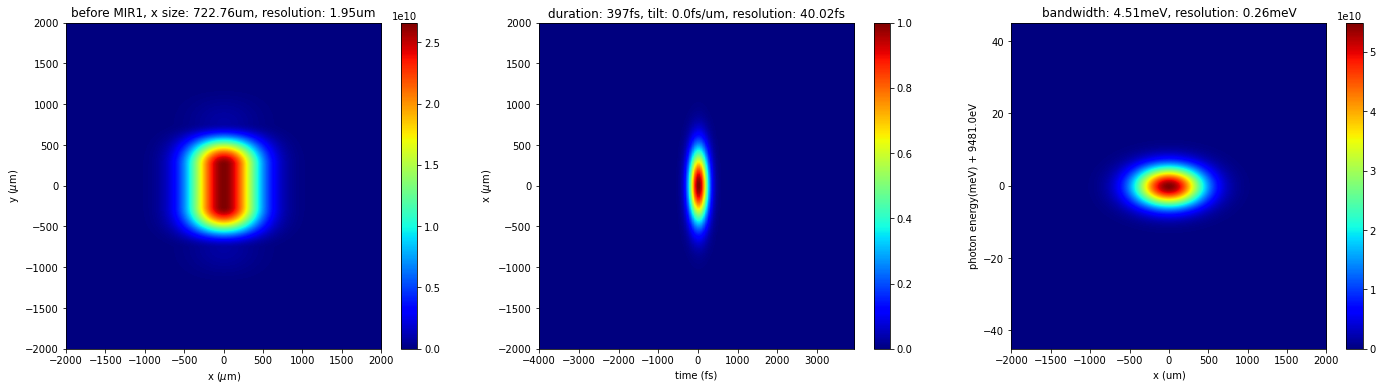

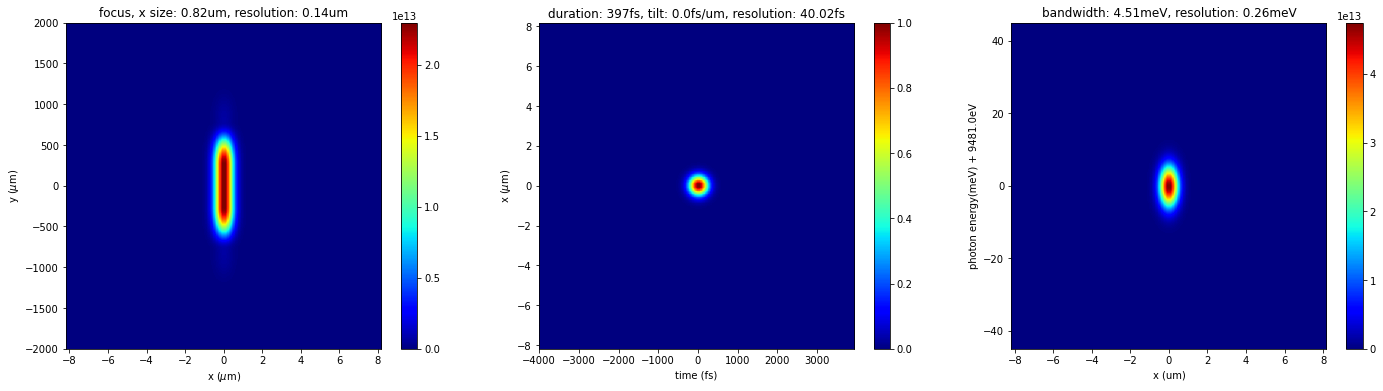

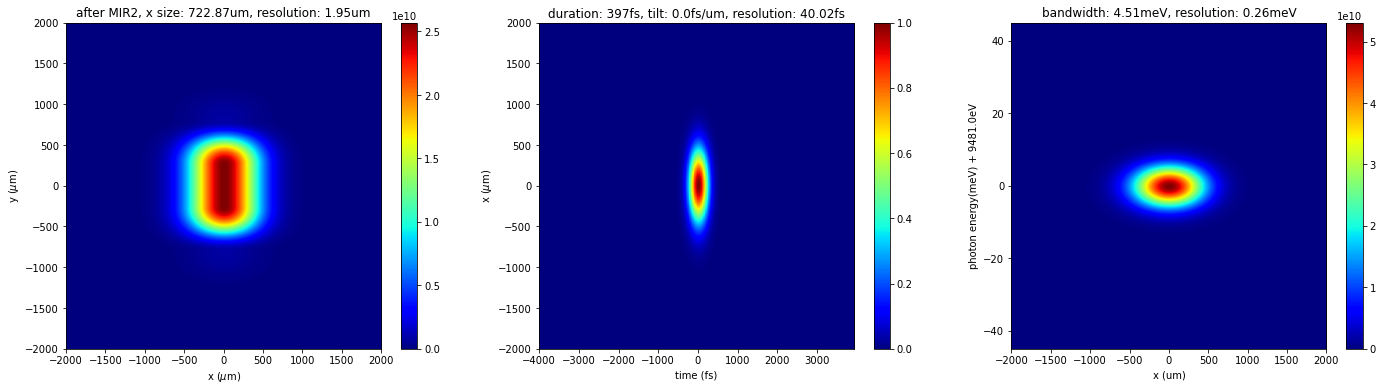

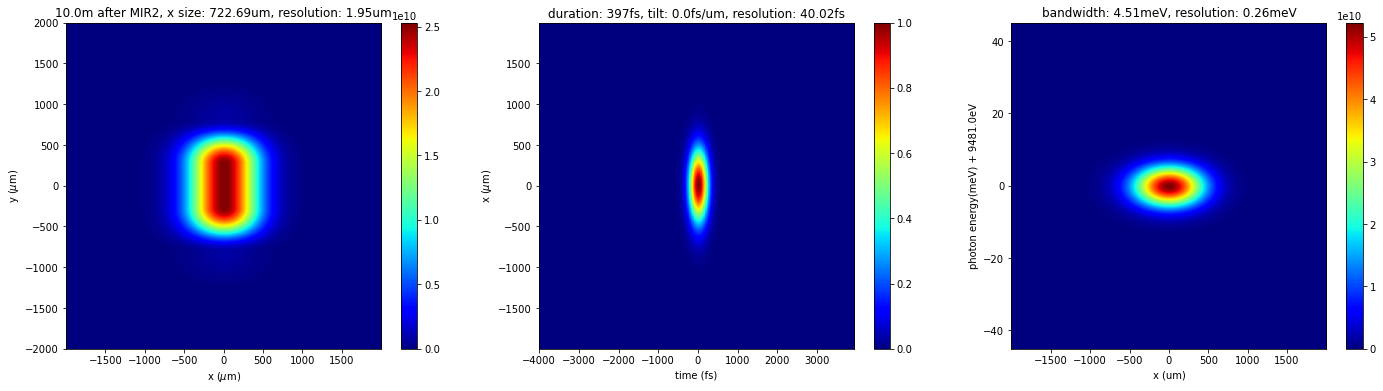

In [10]:
## open slit
if __name__ == '__main__':
    time_stamp=time()
    main(if_log=0, if_slice=0, d_slit=0.1, i_start=0, if_close=0)
    print('\n\neverything lasted: {}s'.format(round(time()-time_stamp,2)))


In [11]:
# import winsound
# for i in range(3):
#     winsound.Beep(500,1000)
#     winsound.Beep(1000,1000)
